## Deep learning methods

In [1]:
import tensorflow as tf
import regex as re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

### Loading the data

### Testing biLSTM with trainable embedding layer on light cleaning, without lemmatization, and stopword removal

In [2]:
df = joblib.load("preprocessed_df.pkl")
label_names = df.columns[3:-1]
messages = df["message"]
garbage_pattern = re.compile(r'(https?://\S+|https?\s\S*|www\.\S+|\bhttps?\b)|[@#]\w+|\d+|[^\w\s]|_')
def text_preprocessor(s: str):
    s = s.lower()              
    #replaces matching stuff with whitespace                 
    s = garbage_pattern.sub(' ', s)
    #cllapses whitespaces and removes trailing, starting whitespaces                
    s = re.sub(r'\s+', ' ', s).strip()
    return s

messages = messages.apply(text_preprocessor)
messages = list(messages.values)
print(label_names)

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')


In [3]:
VOCAB = 10000

text_train, texts_test, y_train, y_test = train_test_split(messages, df[label_names].to_numpy(), test_size=0.2, random_state=255)
tokenizer = tf.keras.preprocessing.text.Tokenizer(VOCAB, lower=False)
tokenizer.fit_on_texts(text_train)
text_train = tokenizer.texts_to_sequences(text_train)
texts_test = tokenizer.texts_to_sequences(texts_test)
text_train = tf.keras.preprocessing.sequence.pad_sequences(text_train, maxlen=50, padding="post")
texts_test =  tf.keras.preprocessing.sequence.pad_sequences(texts_test, maxlen=50, padding="post")
embeddings_trainable_train_tensors = tf.data.Dataset.from_tensor_slices((text_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
embeddings_trainable_test_tensors = tf.data.Dataset.from_tensor_slices((texts_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

### Deep models

Small LSTM model 

In [4]:
EMBED_DIM = 50


def lstm_model(input_shape, output_dim, lstm_dim: int = 256, embedding_dim: int = None, vocabulary: int = 5000):
    inp = tf.keras.layers.Input(input_shape[1:])
    x = inp
    if embedding_dim:
        x = tf.keras.layers.Embedding(vocabulary, embedding_dim, mask_zero=True)(x)
    else:
        x = tf.keras.layers.Masking()(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=False), merge_mode="sum")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(lstm_dim//2, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(output_dim, activation="sigmoid")(x)
    return tf.keras.Model(inputs = inp, outputs = output)

model_lstm = lstm_model(text_train.shape, output_dim=y_train.shape[1], embedding_dim=EMBED_DIM, vocabulary=VOCAB)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            500000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              628736    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                             

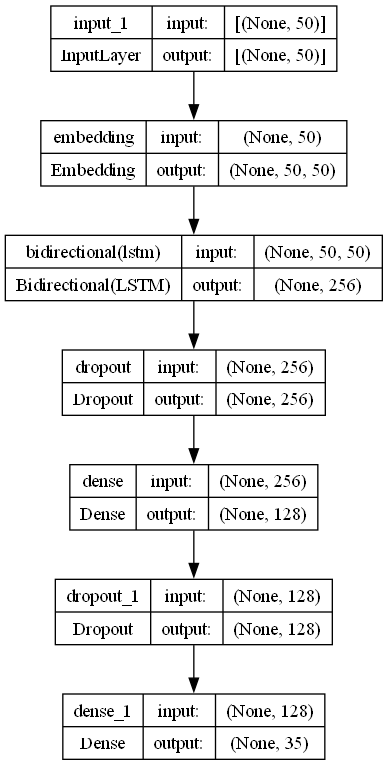

In [5]:
model_lstm.summary()
display(tf.keras.utils.plot_model(model_lstm, show_shapes=True))

### Helper functions

In [6]:
def results(history, epochs, prefix = ""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    auc = history.history[f'auc{prefix}']
    val_auc =  history.history[f'val_auc{prefix}']

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(epochs)
        plt.subplot(1, 2, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(auc, val_auc, "AUC", 2, "ROC (AUC)")
    plt.show()
def eval_model(test_x, test_y, labels, model,):
    preds = model.predict(test_x, verbose = 0)
    preds = (preds > 0.5).astype(np.int32).squeeze()
    cr = classification_report(test_y, preds, target_names = labels, zero_division=np.nan)
    print(cr)
    def plot_cms(y_test, preds, labels):
        plt.figure(figsize=(15,15))
        for i in range(len(labels)):
            plt.subplot(6,6,i+1)
            plt.title(f"{labels[i]}")
            cm = confusion_matrix(y_test[:, i], preds[:, i], normalize = "true")
            sns.heatmap(cm, annot=True, fmt=".2f", cbar=False, cmap="mako")
            plt.ylabel("True")
            plt.xlabel("Pred")
        plt.tight_layout()
        plt.suptitle("Per class confusion matrices, normilized by true (diagonal is recall)")
        plt.subplots_adjust(top=0.95)
        plt.show()
    plot_cms(test_y, preds, labels)


### Trainable embeddings

In [7]:
EPOCHS = 5

model_lstm.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = tf.keras.metrics.AUC(multi_label=True))
history = model_lstm.fit(embeddings_trainable_train_tensors, validation_data = embeddings_trainable_test_tensors , epochs = EPOCHS)

Epoch 1/5
656/656 [==============================] - 39s 44ms/step - loss: 0.2245 - auc: 0.6231 - val_loss: 0.1875 - val_auc: 0.7527
Epoch 2/5
656/656 [==============================] - 32s 49ms/step - loss: 0.1746 - auc: 0.7734 - val_loss: 0.1749 - val_auc: 0.7795
Epoch 3/5
656/656 [==============================] - 28s 43ms/step - loss: 0.1561 - auc: 0.8262 - val_loss: 0.1723 - val_auc: 0.7863
Epoch 4/5
656/656 [==============================] - 28s 42ms/step - loss: 0.1435 - auc: 0.8579 - val_loss: 0.1748 - val_auc: 0.7841
Epoch 5/5
656/656 [==============================] - 27s 41ms/step - loss: 0.1327 - auc: 0.8849 - val_loss: 0.1766 - val_auc: 0.7895


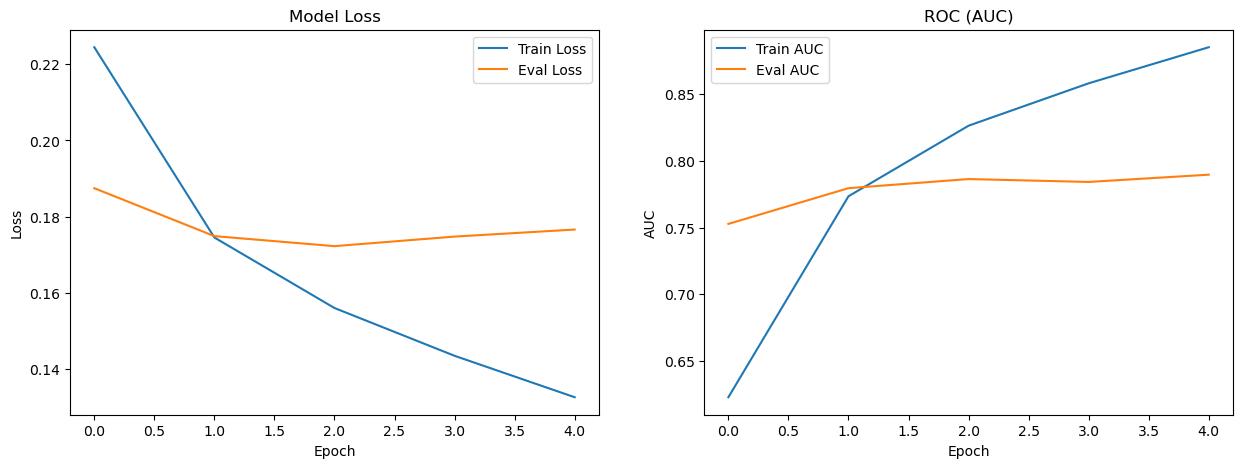

                        precision    recall  f1-score   support

               related       0.87      0.91      0.89      4018
               request       0.71      0.66      0.69       911
                 offer        nan      0.00      0.00        21
           aid_related       0.67      0.80      0.73      2232
          medical_help       0.36      0.20      0.25       438
      medical_products       0.45      0.24      0.32       265
     search_and_rescue        nan      0.00      0.00       152
              security        nan      0.00      0.00        82
              military       0.51      0.22      0.31       166
                 water       0.56      0.33      0.41       345
                  food       0.77      0.69      0.73       607
               shelter       0.69      0.47      0.56       465
              clothing       1.00      0.01      0.02        82
                 money        nan      0.00      0.00       120
        missing_people        nan      

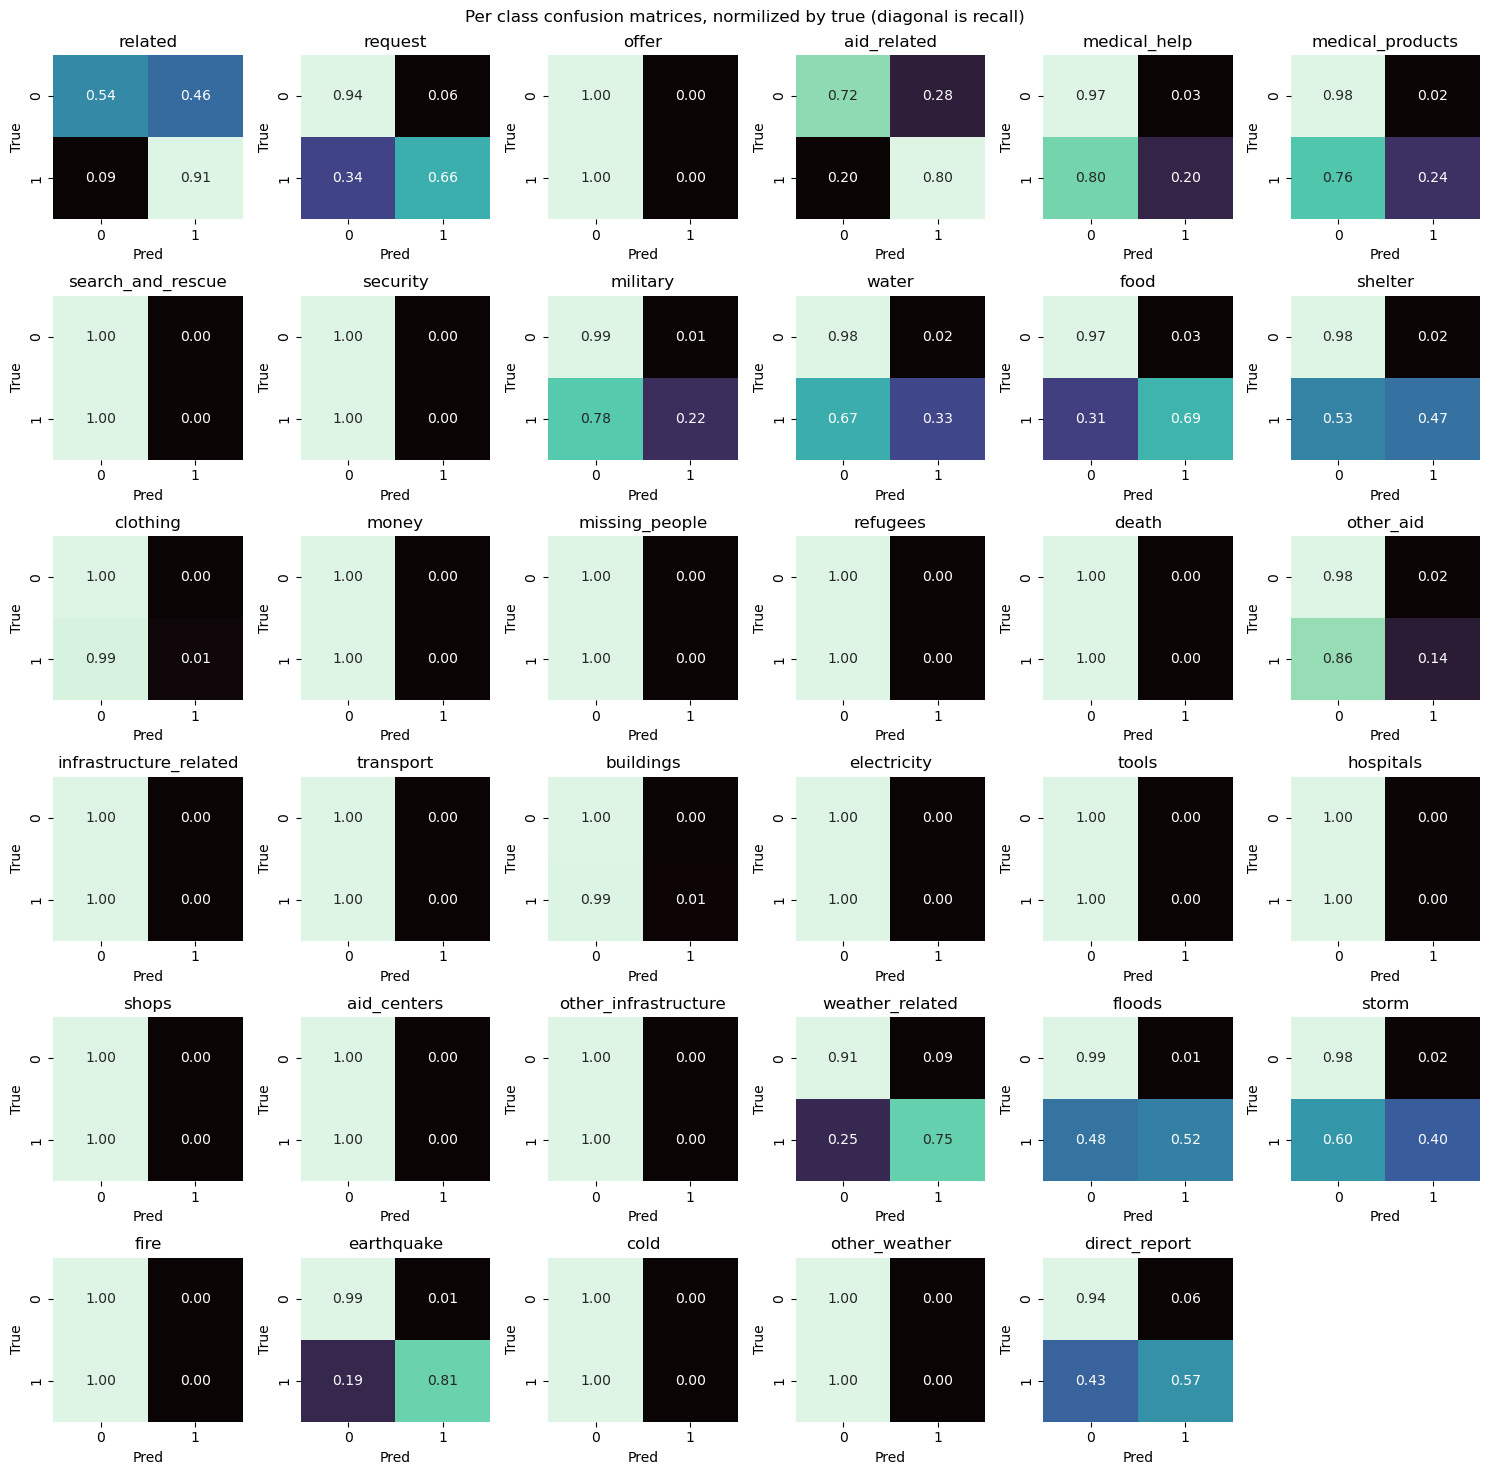

In [8]:
results(history, EPOCHS,  "")
eval_model(texts_test, y_test, label_names, model_lstm)